In [1]:
import pandas as pd
import os
import itertools
from root_pandas import read_root
#import tensorflow as tf
import seaborn as sn
import dask.dataframe as dd
import matplotlib.pyplot as plt 
# import dask.array as da
import numpy as np
import time
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold

Welcome to JupyROOT 6.16/00


Using TensorFlow backend.


In [2]:
#Read background and signal samples from ROOT files
#BACKGROUND
'''CONTINUUM BACKGROUND'''
Continuum_bkg = pd.DataFrame() #empty dataframe to contain continuum bkg samples
#export all continuum bkg root files to a single pandas dataframe
for file in os.listdir("../DATA/Background/Continuum/"):
    continuum_temp = pd.DataFrame()
    continuum_temp = read_root("../DATA/Background/Continuum/" + file, 'B0')
    frames=[Continuum_bkg, continuum_temp]
    Continuum_bkg= pd.concat(frames, ignore_index=True)

/home/guida/anaconda3/envs/myrootenv/lib/python3.7/site-packages/root_pandas/readwrite.py:320: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  df = df.reindex_axis(columns, axis=1, copy=False)


In [3]:
'''PEAKING BACKGROUND'''
Peaking_bkg = pd.DataFrame() #empty dataframe to contain peaked bkg samples
#export all peaking bkg root files to a single pandas dataframe
for file in os.listdir("../DATA/Background/Peaking/"):
    peaking_temp = pd.DataFrame()
    peaking_temp = read_root("../DATA/Background/Peaking/" + file, 'B0')
    frames=[Peaking_bkg, peaking_temp]
    Peaking_bkg= pd.concat(frames)    

In [4]:
'''SIGNAL'''
Signal = pd.DataFrame() #empty dataframe to contain signal samples
#export all peaking bkg root files to a single pandas dataframe
for file in os.listdir("../DATA/Signal/"):
    signal_temp = pd.DataFrame()
    signal_temp = read_root("../DATA/Signal/" + file, 'B0')
    frames=[Signal, signal_temp]
    Signal= pd.concat(frames, ignore_index=True) 


#Signal: require B0_isSignal == True
Signal=Signal[Signal['B0_isSignal']== True]
#reset row indexing
Signal.reset_index(drop=True, inplace=True)
print("Signal shape : ",Signal.shape)

#Continuum: require B0_isContinuumEvent == True
Continuum_bkg=Continuum_bkg[Continuum_bkg['B0_isContinuumEvent']== True]
#reset row indexing
Continuum_bkg.reset_index(drop=True, inplace=True)
print("Continuum_bkg shape : ",Continuum_bkg.shape)

#Peaking: require B0_isNotContinuumEvent == True
Peaking_bkg=Peaking_bkg[Peaking_bkg['B0_isNotContinuumEvent']== True]
#reset row indexing
Peaking_bkg.reset_index(drop=True, inplace=True)
print("Peaking_bkg shape : ",Peaking_bkg.shape)


# '''DNN Error: Input contains NaN, infinity or a value too large for dtype('float64')'''
# #Check if there are NaN in datasets (see below why)
# Peaking_bkg.replace([np.inf, -np.inf], np.nan)
# Continuum_bkg.replace([np.inf, -np.inf], np.nan)
# Signal.replace([np.inf, -np.inf], np.nan)
# N_peak=Peaking_bkg.isnull().T.any().T.sum()
# print(N_peak)
# N_cont=Continuum_bkg.isnull().T.any().T.sum()
# print(N_cont)
# N_sig=Signal.isnull().T.any().T.sum()
# print(N_sig)


Important_variables=[
"B0_Pcms","B0_P4cms",
"B0_etap_Pcms" ,
"B0_etap_P4cms",
"B0_etap_eta_gamma0_Pcms",
"B0_etap_eta_gamma0_P4cms",   
"B0_etap_eta_gamma1_Pcms",  
"B0_etap_eta_gamma1_P4cms",            
"B0_etap_pi1_Pcms",                     
"B0_K_S0_P4cms",
"B0_K_S0_M",                
"B0_M",          
"B0_etap_M",     
"B0_etap_eta_M",
"B0_TrCSMVA"]

Signal shape :  (41243, 391)
Continuum_bkg shape :  (3429, 391)
Peaking_bkg shape :  (249, 391)


In [6]:
Signal_selection = Signal[Important_variables]
Continuum_bkg_selection= Continuum_bkg[Important_variables]
Peaking_bkg_selection= Peaking_bkg[Important_variables]

print("Signal shape : ",Continuum_bkg_selection.shape)
print("Continuum_bkg shape : ",Peaking_bkg_selection.shape)
print("Peaking_bkg shape : ",Signal_selection.shape)


#The Dataframe contains arrays as elements, I create a new column for each component
Signal_comp = pd.concat([pd.DataFrame(Signal_selection[c].tolist()).add_prefix(c[:c.index('4')]).add_suffix(c[c.index('4')+1:]) if '4' in c else Signal_selection[c] for c in Signal_selection], axis=1)
Peaking_bkg_comp = pd.concat([pd.DataFrame(Peaking_bkg_selection[c].tolist()).add_prefix(c[:c.index('4')]).add_suffix(c[c.index('4')+1:]) if '4' in c else Peaking_bkg_selection[c] for c in Peaking_bkg_selection], axis=1)
Continuum_bkg_comp = pd.concat([pd.DataFrame(Continuum_bkg_selection[c].tolist()).add_prefix(c[:c.index('4')]).add_suffix(c[c.index('4')+1:]) if '4' in c else Continuum_bkg_selection[c] for c in Continuum_bkg_selection], axis=1)

Signal shape :  (3429, 15)
Continuum_bkg shape :  (249, 15)
Peaking_bkg shape :  (41243, 15)


In [7]:
from random import seed
from random import randint
# seed random number generator
n_seed=2347
seed(n_seed)

In [8]:
import sklearn
from sklearn.model_selection import train_test_split
Signal_comp['Type'] = 2 #Signal label == 2
Peaking_bkg_comp['Type'] = 1 # Peaking background label == 1
Continuum_bkg_comp['Type'] = 0 #Continuum backgroun label == 0
# Put in a dataframe randomly shuffled the lines
Sum_BS = pd.concat([Signal_comp,Peaking_bkg_comp,Continuum_bkg_comp]).sample(frac=1)
X = Sum_BS.drop('Type',axis=1)
Y = Sum_BS['Type']
# Dataframe divided into 80% of train data and 20% of test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8,random_state=randint(10**6,10**9))
# Standardize features by removing the mean and scaling to unit variance

In [9]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
print(ss.fit(X_train))
# The averages and standard deviations of all the databases are saved, 
# now with transfer I modify the data (Train and Test) in practice
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

# '''DNN Error: Input contains NaN, infinity or a value too large for dtype('float64')'''
# #Check if there are NaN in X_train and X_test
# Null_X_train=np.isnan(X_train)#.T.any().T.sum()
# print(Null_X_train)
# Null_X_test=np.isnan(X_test)#.T.any().T.sum()
# print(Null_X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [11]:
def build_deep_neural_network(layers):
    # create model
    model = Sequential()
    model.add(Dense(layers[0], input_shape=(X_train.shape[1],), activation='relu'))
    for i in range(1,len(layers)):
#     model.add(Dropout(rate=0.1))
        model.add(Dense(layers[i], activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
%%time
layers=[200, 300, 100]
bestModel = build_deep_neural_network(layers)
bestModel.fit(X_train, Y_train, epochs=5,verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
CPU times: user 1min 59s, sys: 1min 15s, total: 3min 15s
Wall time: 3min 7s


2019-07-03 11:20:26.454034: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-07-03 11:20:26.492200: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2592000000 Hz
2019-07-03 11:20:26.493876: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55d52b67bd30 executing computations on platform Host. Devices:
2019-07-03 11:20:26.493916: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-3
OMP: Info #156: KMP_AFFINITY: 4 available OS procs
OMP: Info #157: KMP_AFFINITY: Uniform topology
OMP: Info #179: KMP_AFFINITY: 1 packages x 2 cores/pkg x 2 threads/core (2 total cores)
OMP: Info #214: KMP_AFFI

In [13]:
from sklearn.metrics import confusion_matrix
Y_train_predict = bestModel.predict(X_train)
Y_test_predict = bestModel.predict(X_test)
Y_test_mo=pd.get_dummies(Y_test[:])
Y_test_predict_mo=Y_test_predict.round()
cnf_matrix = confusion_matrix(Y_test_mo.values.argmax(axis=1), Y_test_predict_mo.argmax(axis=1))
# confusion_matrix(Y_test_mo, Y_test_predict_mo, labels=['Continuum_bkg', 'Peaking_bkg', 'Signal'])

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(200,100))
    plt.tight_layout()

Normalized confusion matrix
[[9.64338782e-01 0.00000000e+00 3.56612184e-02]
 [5.30612245e-01 4.08163265e-02 4.28571429e-01]
 [7.26128525e-03 1.21021421e-04 9.92617693e-01]]


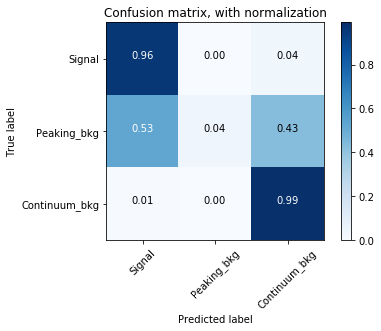

<Figure size 14400x7200 with 0 Axes>

In [15]:
plot_confusion_matrix(cnf_matrix, classes=['Signal', 'Peaking_bkg', 'Continuum_bkg'],title='Confusion matrix, with normalization')